In [1]:
import os
import sys
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt

Create grid from scratch

In [2]:
# Initialize SfincsModel with the artifact data catalog which contains data for North Italy
sf = SfincsModel(data_libs=["artifact_data"])

In [3]:
inp_dict = {
    "x0": 268650,
    "y0": 5018550,
    "dx": 150.0,
    "dy": 150.0,
    "nmax": 272,
    "mmax": 425,
    "rotation": 0,
    "crs": 32633,
}
# create grid
sf.create_grid(grid_type="regular", **inp_dict)
# the input file is automatically updated
sf.config
#TODO add defaults values?

{'x0': 268650,
 'y0': 5018550,
 'dx': 150.0,
 'dy': 150.0,
 'nmax': 272,
 'mmax': 425,
 'rotation': 0,
 'crs': 32633}

Create mask purely based on include- and exclude polygons

In [4]:
from hydromt_sfincs import utils

file_name = "sfincs_coastal//include.pol"
gdf_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

<AxesSubplot: >

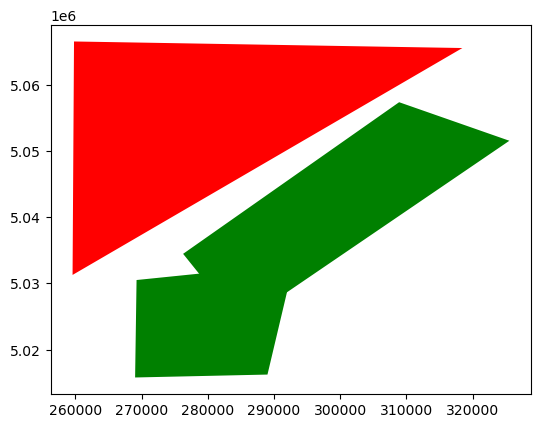

In [5]:
file_name = "sfincs_coastal//exclude.pol"
gdf_exclude = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

fig, ax = plt.subplots(1, 1)
gdf_include.plot(ax=ax, color="green")
gdf_exclude.plot(ax=ax, color="red")

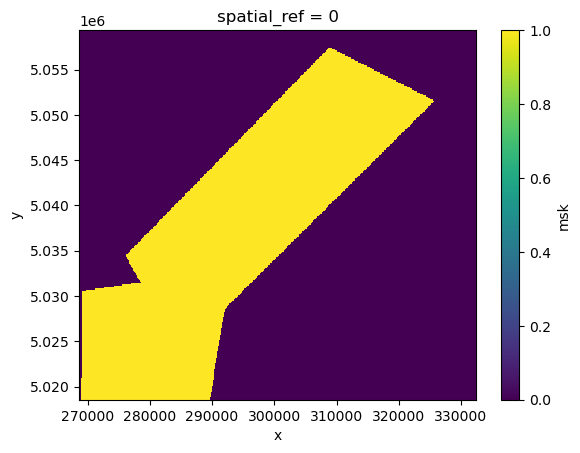

In [6]:
sf.create_mask_active(gdf_include=gdf_include, gdf_exclude=gdf_exclude)
sf.mask.plot.imshow()

Also take into account topobathy information

<AxesSubplot: >

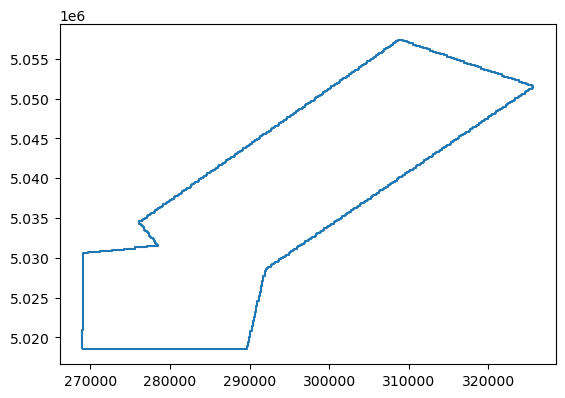

In [7]:
sf.region.boundary.plot()

In [8]:
# sf.grid.data.raster.set_crs(sf.grid.crs)
da_dep1 = sf.data_catalog.get_rasterdataset(
    "merit_hydro", variables=["elevtn"], geom=sf.region, buffer=5
)

da_dep2 = sf.data_catalog.get_rasterdataset(
    "gebco", variables=["elevtn"], geom=sf.region, buffer=5
)

# List[xr.DataArray]
da_list = [da_dep1, da_dep2]

In [9]:
# Add depth information to modelgrid
# TODO rename create_topobathy?
sf.create_dep(da_list=da_list)
sf.config.update({"depfile": "sfincs.dep"})

13 gaps outside valid elevation range < 10 km2.
0 regions < 10 km2 dropped.


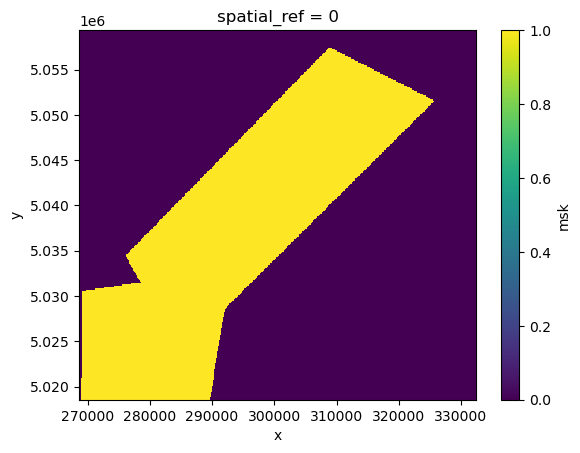

In [10]:
# play around with include, drop_area and fill_area
mask = sf.create_mask_active(
    elv_min=-5, elv_max=10, fill_area=10, drop_area=10, gdf_include=gdf_include
)

# TODO: make updating inp with indexfile / mskfile part of create_mask_active or add to default
sf.config.update({"indexfile": "sfincs.ind"})
sf.config.update({"mskfile": "sfincs.msk"})

mask.plot.imshow()

Mask boundaries

In [11]:
file_name = "sfincs_coastal\\bnd_wl.pol"
gdf_wl = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

file_name = "sfincs_coastal\\bnd_out.pol"
gdf_outflow = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

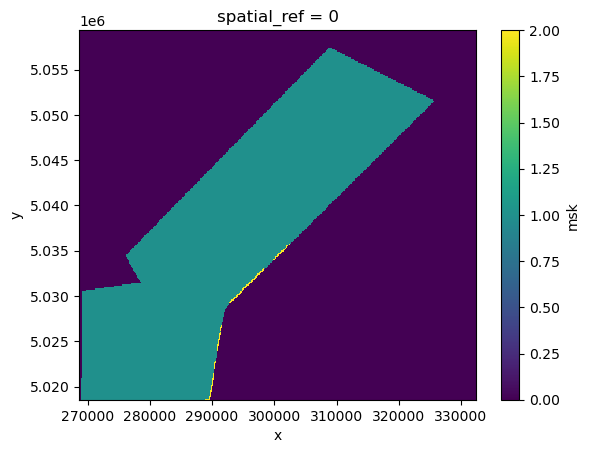

In [12]:
sf.create_mask_bounds(btype="waterlevel", gdf_include=gdf_wl, elv_max=-2)
sf.create_mask_bounds(btype="outflow", gdf_include=gdf_outflow, elv_min=2)

sf.mask.plot.imshow()

In [13]:
sf.write_grid(data_vars=["dep"])  # write single grid map
sf.write_grid()  # write all

ValueError: Root unknown, use set_root method

In [ ]:
sf.root = "tmp_example"
sf.write()